In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


# Data Ingest

## Loading the train dataset

In [2]:
TRAIN_DATASET_FILE_LOCATION = '/kaggle/input/emotions-dataset-for-nlp/train.txt'

train_df = pd.read_csv(TRAIN_DATASET_FILE_LOCATION, sep=';', names=['text','emotion'])

In [3]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
len(train_df)

16000

In [5]:
train_df_tally = train_df['emotion'].value_counts()
train_df_tally

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [6]:
train_df_tally/sum(train_df_tally)

joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: emotion, dtype: float64

📔 We have an imbalanced dataset with the top 2 emotions comprising `~30%` of the dataset.

## Loading the validation dataset

In [7]:
VALIDATION_DATASET_FILE_LOCATION = '/kaggle/input/emotions-dataset-for-nlp/val.txt'

val_df = pd.read_csv(VALIDATION_DATASET_FILE_LOCATION, sep=';', names=['text','emotion'])
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [8]:
val_df_tally = val_df['emotion'].value_counts()
val_df_tally/sum(val_df_tally)

joy         0.3520
sadness     0.2750
anger       0.1375
fear        0.1060
love        0.0890
surprise    0.0405
Name: emotion, dtype: float64

# Exploratory Data Analysis (EDA)

* What are the classes?
* What is the distribution of length of the text?

In [9]:
CLASSES = train_df['emotion'].unique()
CLASSES

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [10]:
length_array = [len(sent.split()) for sent in train_df['text']]
text_length_df = pd.DataFrame(length_array, columns=["text_length"])
text_length_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
text_length,16000.0,19.166313,10.986905,2.0,11.0,17.0,25.0,66.0


<Axes: ylabel='Frequency'>

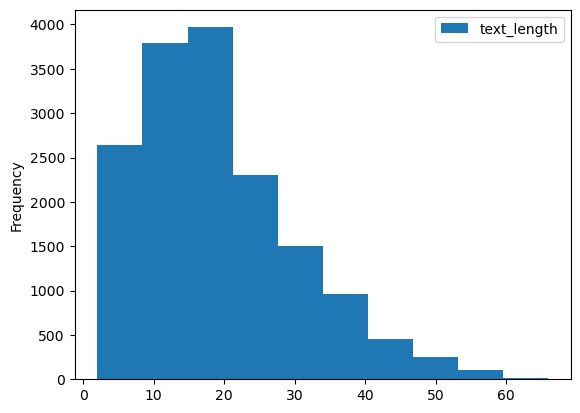

In [11]:
text_length_df.plot(kind='hist')

In [12]:
index_90th = int(len(length_array) * 0.90)
sorted(length_array)[index_90th]

35

📔 We'll use length `35` for out sentences as it covers `90%` of the lengths in our train dataset.

# Modelling

* **Model 0: Multinomial Naive Bayes (baseline)**
* **Model 1: Feedforward Neural Network**
* **Model 2: LSTM**
* **Model 3: GRU**
* **Model 4: Bidirectional**
* **Model 5: Conv1D**
* **Model 6: USE pre-trained encoder**

## Loading the test dataset

In [13]:
TEST_DATASET_FILE_LOCATION = '/kaggle/input/emotions-dataset-for-nlp/test.txt'

test_df = pd.read_csv(TRAIN_DATASET_FILE_LOCATION, sep=';', names=['text','emotion'])

In [14]:
test_df.head(10)

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [15]:
test_df.shape

(16000, 2)

In [16]:
tally_test_df = test_df['emotion'].value_counts()

tally_test_df, tally_test_df/sum(tally_test_df)

(joy         5362
 sadness     4666
 anger       2159
 fear        1937
 love        1304
 surprise     572
 Name: emotion, dtype: int64,
 joy         0.335125
 sadness     0.291625
 anger       0.134937
 fear        0.121063
 love        0.081500
 surprise    0.035750
 Name: emotion, dtype: float64)

In [17]:
X_test, y_test = test_df['text'], test_df['emotion']

X_test.head(), y_test.head()

(0                              i didnt feel humiliated
 1    i can go from feeling so hopeless to so damned...
 2     im grabbing a minute to post i feel greedy wrong
 3    i am ever feeling nostalgic about the fireplac...
 4                                 i am feeling grouchy
 Name: text, dtype: object,
 0    sadness
 1    sadness
 2      anger
 3       love
 4      anger
 Name: emotion, dtype: object)

## Baseline model: Multinomial Naive Bayes

In [18]:
X_train, y_train = train_df['text'], train_df['emotion']

X_train.head(10), y_train.head(10)

(0                              i didnt feel humiliated
 1    i can go from feeling so hopeless to so damned...
 2     im grabbing a minute to post i feel greedy wrong
 3    i am ever feeling nostalgic about the fireplac...
 4                                 i am feeling grouchy
 5    ive been feeling a little burdened lately wasn...
 6    ive been taking or milligrams or times recomme...
 7    i feel as confused about life as a teenager or...
 8    i have been with petronas for years i feel tha...
 9                                  i feel romantic too
 Name: text, dtype: object,
 0     sadness
 1     sadness
 2       anger
 3        love
 4       anger
 5     sadness
 6    surprise
 7        fear
 8         joy
 9        love
 Name: emotion, dtype: object)

In [19]:
X_val, y_val = val_df['text'], val_df['emotion']

X_val.head(10), y_val.head(10)

(0    im feeling quite sad and sorry for myself but ...
 1    i feel like i am still looking at a blank canv...
 2                       i feel like a faithful servant
 3                    i am just feeling cranky and blue
 4    i can have for a treat or if i am feeling festive
 5    i start to feel more appreciative of what god ...
 6    i am feeling more confident that we will be ab...
 7    i feel incredibly lucky just to be able to tal...
 8            i feel less keen about the army every day
 9             i feel dirty and ashamed for saying that
 Name: text, dtype: object,
 0    sadness
 1    sadness
 2       love
 3      anger
 4        joy
 5        joy
 6        joy
 7        joy
 8        joy
 9    sadness
 Name: emotion, dtype: object)

### TF-IDF Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

vocabulary = tfidf_vectorizer.get_feature_names_out()
vocabulary.shape

(15186,)

In [21]:
vectorized_X_train = tfidf_vectorizer.transform(X_train)

vectorized_X_train.toarray().shape

(16000, 15186)

In [22]:
vectorized_X_train.toarray()[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### The Multinomial Naive Bayes Classifier

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
model_0.fit(X_train, y_train) # TODO: Add validation data

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
model_0_predictions = model_0.predict(X_test)

model_0_predictions

array(['sadness', 'sadness', 'anger', ..., 'joy', 'joy', 'sadness'],
      dtype='<U8')

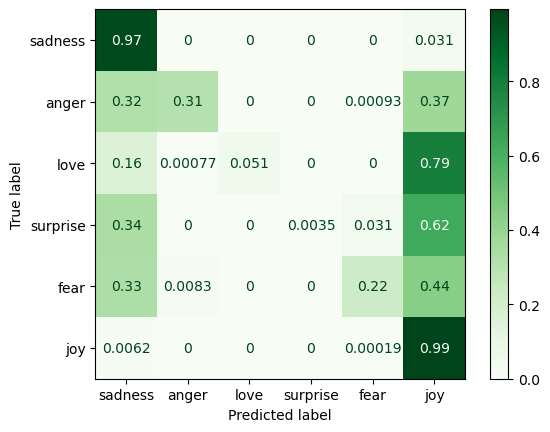

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(y_true, y_predictions):
    cm = confusion_matrix(y_true, y_predictions, 
                          normalize='true',
                          labels=CLASSES)
    ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=CLASSES
    ).plot(cmap='Greens')

show_confusion_matrix(y_test, model_0_predictions)

In [27]:
from sklearn.metrics import balanced_accuracy_score

def score_predictions(y_true, y_pred):
    return {
        'accuracy': balanced_accuracy_score(y_true, y_pred)
    }

score_predictions(y_test, model_0_predictions)

{'accuracy': 0.42477054845941226}